## Experiment tracking using Neptune and MLflow

In [1]:
#import base libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# importing model metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [3]:
# import serializer
import pickle

In [4]:
# import neptune libraries and sklearn integration
import neptune.new as neptune
import neptune.new.integrations.sklearn as npt_skl

In [5]:
# import mlflow and libraries
import mlflow
import mlflow.sklearn

### Load models and variables

In [6]:
# load models
pipeline_lr = pickle.load(open("../bin/models/lr_model.pkl", "rb"))
pipeline_rf = pickle.load(open("../bin/models/rf_model.pkl", "rb"))
pipeline_gbr = pickle.load(open("../bin/models/gbr_model.pkl", "rb"))

In [7]:
# load splitted data
with open("../bin/var/splitted_data.pkl", "rb") as data:
    data_list = pickle.load(data)

In [8]:
X_train = data_list[0]
y_train = data_list[1]
X_test = data_list[2]
y_test = data_list[3]
X_val = data_list[4]
y_val = data_list[5]

In [9]:
for d in data_list:
    print(d.shape)

(591, 10)
(591,)
(127, 10)
(127,)
(127, 10)
(127,)


### Experiment tracking with Neptune

In [10]:
run = neptune.init(
    project="alessandro.cubeddu/omdena-mlops-solar",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjZTRjYjkzNy0wODlhLTQyZmQtODdjYS1kMWM2YzQ1NTY0OTUifQ==",
    name='solar-irradiation',
    source_files=['model_dev_val_export_solar_radiation.ipynb']
)  # your credentials

https://app.neptune.ai/alessandro.cubeddu/omdena-mlops-solar/e/OM-14


Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


#### Track files, models and folders

In [11]:
# tracking files
run["cleaned_datasets"].track_files("../datasets/cleaned/")
run["raw_datasets"].track_files("../datasets/raw/")

# tracking folders
run["notebooks"].track_files("../notebooks/")

#### train and test models while tracking the experiment

Did not log feature importance chart. Error: could not find feature importances param on Pipeline
Did not log feature importance chart. Error: could not find feature importances param on Pipeline
Did not log feature importance chart. Error: could not find feature importances param on Pipeline


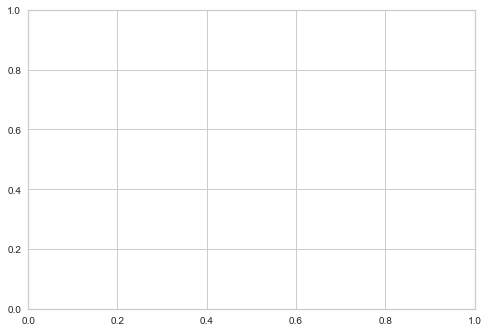

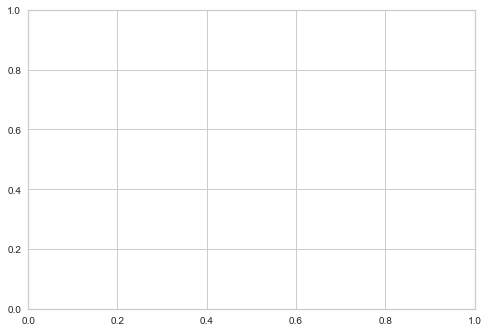

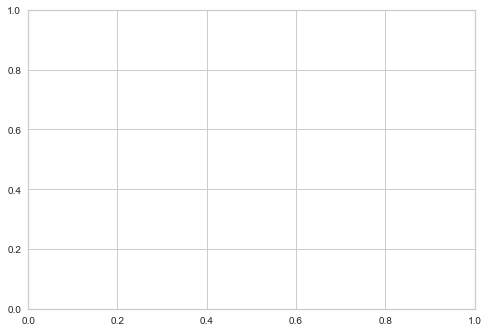

In [12]:
run['lr_summary'] = npt_skl.create_regressor_summary(pipeline_lr, X_train, X_test, y_train, y_test)
run['rfr_summary'] = npt_skl.create_regressor_summary(pipeline_rf, X_train, X_test, y_train, y_test)
run['gbr_summary'] = npt_skl.create_regressor_summary(pipeline_gbr, X_train, X_test, y_train, y_test)

#### stop experiment

In [13]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 107 operations to synchronize with Neptune. Do not kill this process.


All 107 operations synced, thanks for waiting!


### Experiment tracking with MLflow

#### Evaluation of Linear Regressor, Random Forest and Gradient Boosting Regressor

In [14]:
# model metrics for linear regression
y_test_lr_pred = pipeline_lr.predict(X_test)
mse_test_lr = mean_squared_error(y_test, y_test_lr_pred, squared=True)
mae_test_lr = mean_absolute_error(y_test, y_test_lr_pred)
r2_test_lr = r2_score(y_test, y_test_lr_pred)

In [15]:
# model metrics for Random Forest Regressor
y_test_rf_pred = pipeline_rf.predict(X_test)
mse_test_rf = mean_squared_error(y_test, y_test_rf_pred, squared=True)
mae_test_rf = mean_absolute_error(y_test, y_test_rf_pred)
r2_test_rf = r2_score(y_test, y_test_rf_pred)

In [16]:
# model metrics for Gradient Boosting Regressor
y_test_gbr_pred = pipeline_gbr.predict(X_test)
mse_test_gbr = mean_squared_error(y_test, y_test_gbr_pred, squared=True)
mae_test_gbr = mean_absolute_error(y_test, y_test_gbr_pred)
r2_test_gbr = r2_score(y_test, y_test_gbr_pred)

#### manually log experiment

<span style="color:red"> **Att:** before running commands below, run on the bash (in the same folder of this file , i.e. notebooks/)the following command:   
    $ mlflow server --backend-store-uri sqlite:///mlflow.db  --default-artifact-root ./artifacts --host 0.0.0.0
</span>

In [17]:
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
experiment = mlflow.get_experiment('0')

In [18]:
print("Name of experiment: {}".format(experiment.name))
print("Location of Artifact: {}".format(experiment.artifact_location))
print("Life cycle phase: {}".format(experiment.lifecycle_stage))
print("Experiment_ID: {}".format(experiment.experiment_id))

Name of experiment: Default
Location of Artifact: ./artifacts/0
Life cycle phase: active
Experiment_ID: 0


In [19]:
# start experiment tracking
run = mlflow.start_run(run_name="solar_irradiation")
run_id = run.info.run_id

In [20]:
run_id

'20fdfb2970fb493a85ebfd56848f5416'

In [21]:
# log mlflow attributes for mlflow UI

# log metrics for linear regression
mlflow.log_metric('mse_lr', mse_test_lr)
mlflow.log_metric('mae_lr', mae_test_lr)
mlflow.log_metric('r2_lr', r2_test_lr)

# log metrics for Random Forest regressor
mlflow.log_metric('mse_rf', mse_test_rf)
mlflow.log_metric('mae_rf', mae_test_rf)
mlflow.log_metric('r2_rf', r2_test_rf)

# log metrics for Gradient Boosting Regressor
mlflow.log_metric('mse_gbr', mse_test_gbr)
mlflow.log_metric('mae_gbr', mae_test_gbr)
mlflow.log_metric('r2_gbr', r2_test_gbr)

In [22]:
mlflow.sklearn.get_default_conda_env()

{'name': 'mlflow-env',
 'channels': ['conda-forge'],
 'dependencies': ['python=3.9.7',
  'pip',
  {'pip': ['mlflow', 'scikit-learn==0.24.2']}]}

In [23]:
type(pipeline_lr)

sklearn.pipeline.Pipeline

In [24]:
# log models experiments
path = 'default'
mlflow.sklearn.log_model(pipeline_lr, path, registered_model_name='linear-reg-model')
mlflow.sklearn.log_model(pipeline_rf, path, registered_model_name='random-forest-reg-model')
mlflow.sklearn.log_model(pipeline_gbr, path, registered_model_name='gradient-boosting-reg-model')


Successfully registered model 'linear-reg-model'.
2022/01/04 10:41:15 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: linear-reg-model, version 1
Created version '1' of model 'linear-reg-model'.
Successfully registered model 'random-forest-reg-model'.
2022/01/04 10:41:17 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: random-forest-reg-model, version 1
Created version '1' of model 'random-forest-reg-model'.
Successfully registered model 'gradient-boosting-reg-model'.
2022/01/04 10:41:19 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: gradient-boosting-reg-model, version 1
Created version '1' of model 'gradient-boosting-reg-model'.


In [25]:
# log artifacts (output files)

# plots
mlflow.log_artifact("../pictures/lr_pred_and_fit.jpg", artifact_path="plots")
mlflow.log_artifact("../pictures/rf_pred_and_fit.jpg", artifact_path="plots")
mlflow.log_artifact("../pictures/gbr_pred_and_fit.jpg", artifact_path="plots")
mlflow.log_artifact("../pictures/lr_jointplot.jpg", artifact_path="plots")
mlflow.log_artifact("../pictures/rf_jointplot.jpg", artifact_path="plots")
mlflow.log_artifact("../pictures/gbr_jointplot.jpg", artifact_path="plots")

# features
mlflow.log_artifact("../datasets/cleaned/train.csv", artifact_path="features")
mlflow.log_artifact("../datasets/cleaned/test.csv", artifact_path="features")
mlflow.log_artifact("../datasets/cleaned/validation.csv", artifact_path="features")

In [26]:
# end experiment
mlflow.end_run()

#### Auto log experiment

In [27]:
# enable auto logging --> log_models=True means that "trained models are logged as MLflow model artifacts"
mlflow.sklearn.autolog(log_models=True)

In [28]:
with mlflow.start_run(experiment_id=experiment.experiment_id, run_name="auto_log_models") as run:
    pipeline_lr.fit(X_train, y_train)
    y_test_lr_autologPred = pipeline_lr.predict(X_test)
    pipeline_rf.fit(X_train, y_train)
    y_test_rf_autologPred = pipeline_rf.predict(X_test)
    pipeline_gbr.fit(X_train, y_train)
    y_test_gbr_autologPred = pipeline_gbr.predict(X_test)

2022/01/04 10:41:20 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('columntransformer', ColumnTransformer(transformers=[('OneHot',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['month', 'yea...`
2022/01/04 10:41:20 WARNING mlflow.utils: Truncated the value of the key `columntransformer`. Truncated value: `ColumnTransformer(transformers=[('OneHot',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['month', 'year']),
                 ...`
2022/01/04 10:41:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/cubo/anaconda3/envs/MLOps_Omdena/lib/python3.9/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in 

In [29]:
# end tracking
mlflow.end_run()